In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import calendar
import os
from urllib.request import urlretrieve

In [2]:
#download data if not already present
url = 'http://www.cryptodatadownload.com/cdd/Kraken_BTCUSD_d.csv'
filename = 'Kraken_BTCUSD_d.csv'

if not os.path.exists(filename):
    urlretrieve(url, filename)

In [3]:
df = pd.read_csv('Kraken_BTCUSD_d.csv', header = 1)

In [4]:
#examine the data
df.head()

,id,unix,date,symbol,open,high,low,close,vwap,Volume BTC,Volume USD,tradecount
0,581711,1.607731e+09,2020-12-12 00:00:00,BTC/USD,18031.5,18274.0,18024.0,18274.0,18154.1,141.889680,2.592892e+06,1057.0
1,581710,1.607645e+09,2020-12-11 00:00:00,BTC/USD,18246.4,18285.0,17572.0,18031.5,17917.9,6183.564176,1.114989e+08,32806.0
2,581709,1.607558e+09,2020-12-10 00:00:00,BTC/USD,18548.4,18557.2,17911.1,18245.5,18230.7,4911.090368,8.960530e+07,26137.0
3,581708,1.607472e+09,2020-12-09 00:00:00,BTC/USD,18313.1,18640.0,17649.9,18548.5,18215.7,7731.943320,1.434160e+08,38590.0
4,581707,1.607386e+09,2020-12-08 00:00:00,BTC/USD,19182.5,19300.0,18120.0,18320.5,18726.4,6386.018894,1.169951e+08,34898.0


In [5]:
df.tail()

#note: dates are in newest to oldest order

,id,unix,date,symbol,open,high,low,close,vwap,Volume BTC,Volume USD,tradecount
2620,362943,1.381363e+09,2013-10-10,BTC/USD,123.84,125.86,123.84,125.86,125.86,2.00,251.71,NaN
2621,362942,1.381277e+09,2013-10-09,BTC/USD,124.18,124.18,123.84,123.84,123.84,2.82,349.95,NaN
2622,362941,1.381190e+09,2013-10-08,BTC/USD,123.61,124.19,123.61,124.18,124.18,3.99,495.14,NaN
2623,362940,1.381104e+09,2013-10-07,BTC/USD,122.00,123.61,122.00,123.61,123.61,0.10,12.36,NaN
2624,362939,1.381018e+09,2013-10-06,BTC/USD,238.00,238.00,122.00,122.00,122.00,0.10,12.20,NaN


In [6]:
#reverse row order to make time in the oldest to newest direction
df = df.reindex(index=df.index[::-1]).reset_index()

In [7]:
#inspect DataFrame
df.info()

#note: trade count is incomplete
#note: date is in str format

#convert date from str to dt
df.date = pd.to_datetime(df.date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       2625 non-null   int64  
 1   id          2625 non-null   int64  
 2   unix        2625 non-null   float64
 3   date        2625 non-null   object 
 4   symbol      2625 non-null   object 
 5   open        2625 non-null   float64
 6   high        2625 non-null   float64
 7   low         2625 non-null   float64
 8   close       2625 non-null   float64
 9   vwap        2625 non-null   float64
 10  Volume BTC  2625 non-null   float64
 11  Volume USD  2625 non-null   float64
 12  tradecount  746 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 266.7+ KB


In [8]:
#To select a single year of data
#df = df[df.date > '2020']

In [9]:
#add columns for day of week & month of year
df['dow_num'] = pd.to_datetime(df.date).dt.dayofweek
df['dow_str'] = pd.to_datetime(df.date).dt.day_name()
df['moy_num'] = pd.to_datetime(df.date).dt.month
df['moy_str'] = pd.to_datetime(df.date).dt.month_name()
df.head()

,index,id,unix,date,symbol,open,high,low,close,vwap,Volume BTC,Volume USD,tradecount,dow_num,dow_str,moy_num,moy_str
0,2624,362939,1.381018e+09,2013-10-06,BTC/USD,238.00,238.00,122.00,122.00,122.00,0.10,12.20,NaN,6,Sunday,10,October
1,2623,362940,1.381104e+09,2013-10-07,BTC/USD,122.00,123.61,122.00,123.61,123.61,0.10,12.36,NaN,0,Monday,10,October
2,2622,362941,1.381190e+09,2013-10-08,BTC/USD,123.61,124.19,123.61,124.18,124.18,3.99,495.14,NaN,1,Tuesday,10,October
3,2621,362942,1.381277e+09,2013-10-09,BTC/USD,124.18,124.18,123.84,123.84,123.84,2.82,349.95,NaN,2,Wednesday,10,October
4,2620,362943,1.381363e+09,2013-10-10,BTC/USD,123.84,125.86,123.84,125.86,125.86,2.00,251.71,NaN,3,Thursday,10,October


Text(0, 0.5, '$USD Daily High')

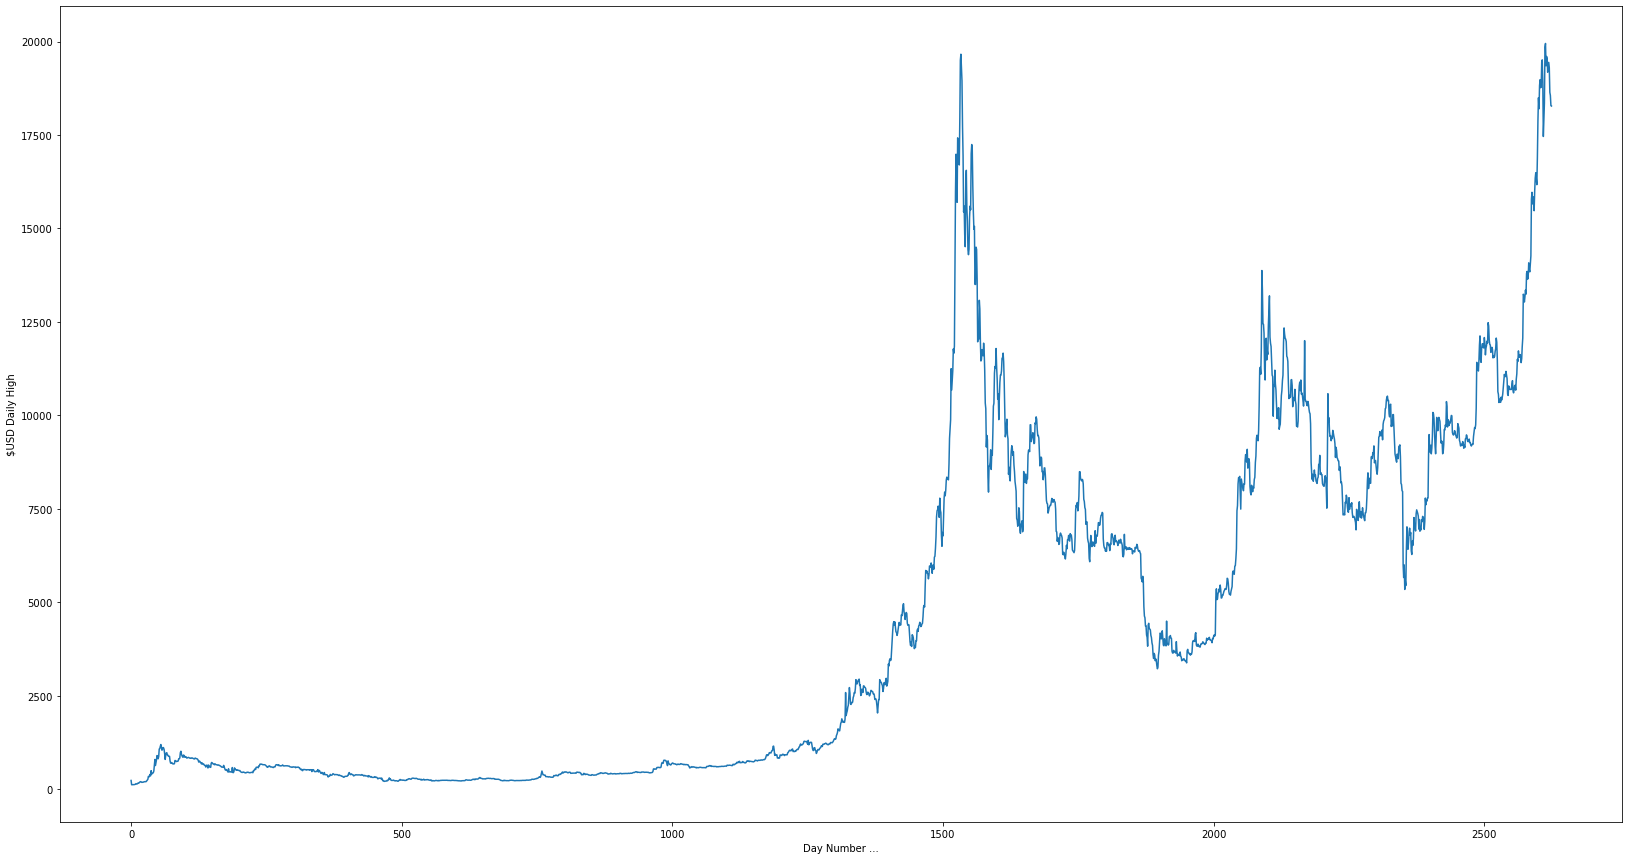

In [10]:
#Inspect the timeseries of high daily price
ax = df.high.plot(figsize=(28,15))
ax.set_xlabel("Day Number ...")
ax.set_ylabel("$USD Daily High")

Text(0, 0.5, 'USD')

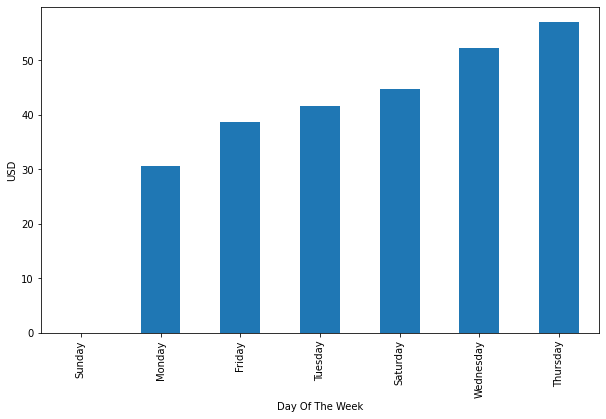

In [11]:
#get the difference in mean value for each day of the week
dow = df.groupby(['dow_str']).mean()['high']
#minus the base amount to leave the difference between lowest mean value and higher mean values
dow = dow-dow.min()
#plot
dow_ax = dow.sort_values().plot.bar(figsize=(10, 6))
dow_ax.set_xlabel("Day Of The Week")
dow_ax.set_ylabel("USD")

#note: Sunday is mean lowest and Thursday is mean highest

Text(0, 0.5, 'USD')

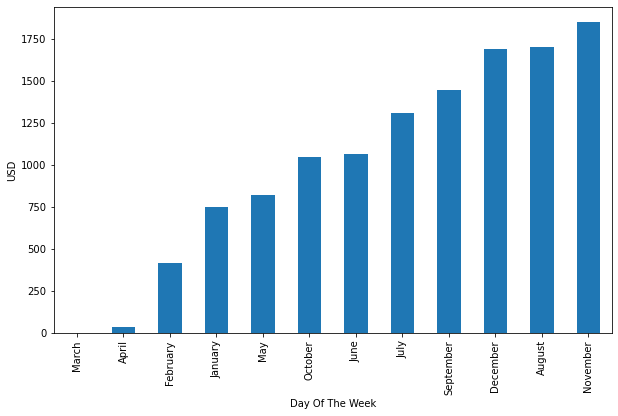

In [12]:
#get the difference in mean value for each month of the year
moy = df.groupby(['moy_str']).mean()['high']

#minus the base amount to leave the difference between lowest mean value and higher mean values
moy = moy-moy.min()

moy_ax = moy.sort_values().plot.bar(figsize=(10,6))
moy_ax.set_xlabel("Day Of The Week")
moy_ax.set_ylabel("USD")

#note: March / April is mean lowest and November is mean highest

In [13]:
#Create empty heatmap for displaying day of week and month of year
days_in_week = 7
months_in_year = 12

day_names = [calendar.day_name[i] for i in range(days_in_week)] 
month_names = [calendar.month_name[i] for i in range(1, 13)] 

btc_heatmap = pd.DataFrame(np.zeros((days_in_week, months_in_year)) , index=day_names, columns=month_names )

btc_heatmap

,January,February,March,April,May,June,July,August,September,October,November,December
Monday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tuesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Friday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Saturday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sunday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df.head()

,index,id,unix,date,symbol,open,high,low,close,vwap,Volume BTC,Volume USD,tradecount,dow_num,dow_str,moy_num,moy_str
0,2624,362939,1.381018e+09,2013-10-06,BTC/USD,238.00,238.00,122.00,122.00,122.00,0.10,12.20,NaN,6,Sunday,10,October
1,2623,362940,1.381104e+09,2013-10-07,BTC/USD,122.00,123.61,122.00,123.61,123.61,0.10,12.36,NaN,0,Monday,10,October
2,2622,362941,1.381190e+09,2013-10-08,BTC/USD,123.61,124.19,123.61,124.18,124.18,3.99,495.14,NaN,1,Tuesday,10,October
3,2621,362942,1.381277e+09,2013-10-09,BTC/USD,124.18,124.18,123.84,123.84,123.84,2.82,349.95,NaN,2,Wednesday,10,October
4,2620,362943,1.381363e+09,2013-10-10,BTC/USD,123.84,125.86,123.84,125.86,125.86,2.00,251.71,NaN,3,Thursday,10,October


In [31]:
#add day of week (DOW) and month of year (MOY) means to heatmap

#iterate over the columns (months)
for month, weekdays in btc_heatmap.iteritems(): 
    #iterate over the rows (weekdays)
    for day, value in weekdays.iteritems():
        #add value to each cell
        btc_heatmap.at[day, month] = df[(df.moy_str == month) & (df.dow_str == day)]['high'].mean()

#round up the values to int
btc_heatmap = btc_heatmap.astype(int)


In [32]:
#review the means
btc_heatmap

,January,February,March,April,May,June,July,August,September,October,November,December
Monday,4276,3584,3263,3512,3912,4250,4847,4994,4749,4271,5373,4546
Tuesday,4281,3709,3250,3276,4085,4371,4805,4873,4702,4487,4958,4904
Wednesday,4273,3747,3148,3282,4256,4255,4713,4902,4817,4325,5143,4971
Thursday,3957,3699,3375,3446,4301,4169,4540,5165,4591,4351,5319,4982
Friday,3840,3641,3400,3232,4158,4400,4509,5057,4614,4365,5103,5304
Saturday,3803,3910,3340,3163,4016,4625,4375,5059,4769,4425,4963,5255
Sunday,3872,3702,3279,3401,4064,4442,4413,4901,4921,4149,5139,4934


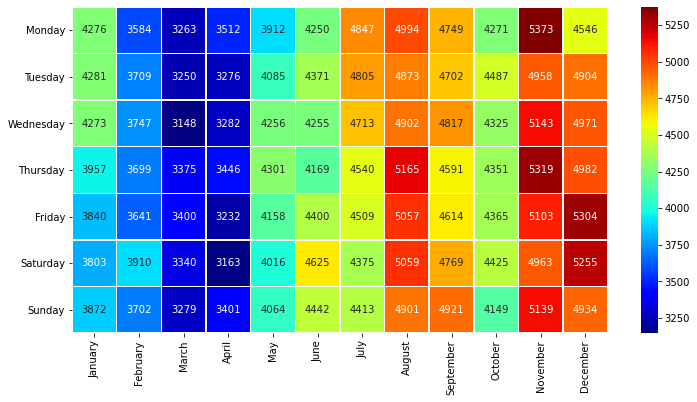

In [34]:
#plot the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
#format the plot
sb.heatmap(btc_heatmap, annot=True, fmt="d", linewidths=.5, cmap='jet')
plt.show()

#note: lowest mean is Wed in Mar
#note: highest mean is Mon in Dec
#note: Clear pattern of lower values in Feb & Mar
#note: Clear patter of higher values in Nov & Dec

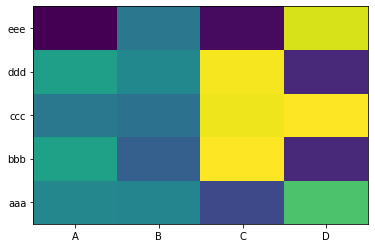

In [18]:


index = ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
columns = ['A', 'B', 'C', 'D']
df = DataFrame(abs(np.random.randn(5, 4)), index=index, columns=columns)

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()